In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/default-credit/sample_submission.csv
/kaggle/input/default-credit/test.csv
/kaggle/input/default-credit/train.csv


In [3]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    
    plt.figure(figsize = (10, 6))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()
    
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [6]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

Пути к директориям и файлам

In [43]:
# input
#DATASET_PATH = '../training_project_data.csv'
#PREP_DATASET_PATH = '../training_project_data_prep.csv'

TRAIN_PATH = '../input/default-credit/train.csv'
TEST_PATH = '../input/default-credit/test.csv'

# output
MODEL_FILE_PATH = '../working/model.pkl'

Data fields

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [8]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df_train.shape

(7500, 17)

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Выделение целевой переменной и групп признаков

In [11]:
TARGET_NAME = 'Credit Default'

BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()




EDA

In [12]:
# Целевая переменная
y = df_train[[TARGET_NAME]]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


Распределение значений целевой переменной

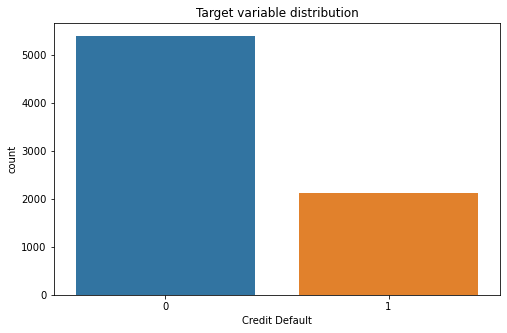

In [13]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

Сэмплы позиций в тренировочном датасете

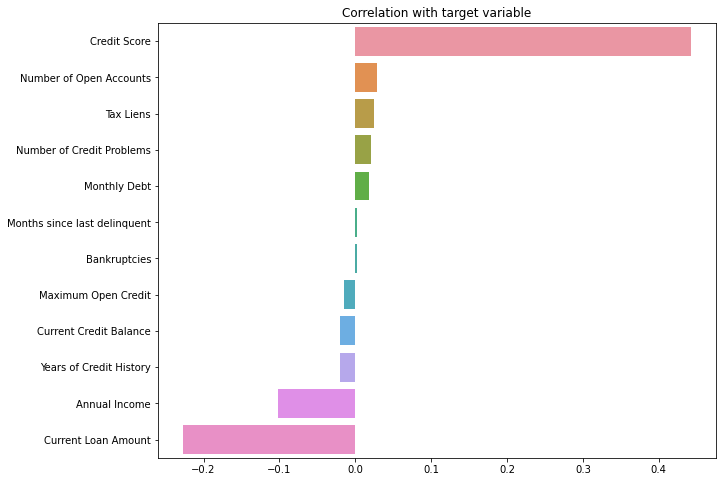

In [14]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

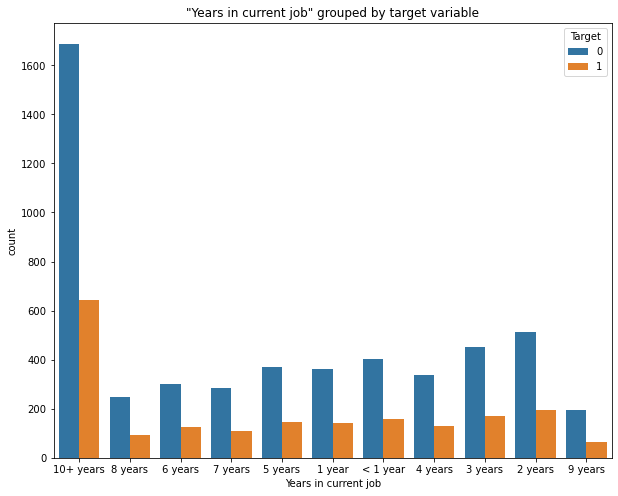

In [15]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('\"Years in current job\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Пустые значения



In [16]:

df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Категориальные признаки

In [17]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Преобразования

In [18]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [19]:
def prepare_usage(data, train = True):
    
    # Пропуски и 0 заменяем на средние
    mean_annual_income = data[~((data['Annual Income'].isna()) | (data['Annual Income'] == 0))]['Annual Income'].mean()
    data.loc[(data['Annual Income'].isna()), ['Annual Income']] = mean_annual_income
    
    median_credit_score = data[~((data['Credit Score'].isna()) | (data['Credit Score'] == 0))]['Credit Score'].mean()
    data.loc[(data['Credit Score'].isna()), ['Credit Score']] = median_credit_score
    
    median_months_since_last_delinquent = data[~((data['Months since last delinquent'].isna()) | 
                                                 (data['Months since last delinquent'] == 0))]['Months since last delinquent'].mean()
    data.loc[(data['Months since last delinquent'].isna()), ['Months since last delinquent']] = median_months_since_last_delinquent
    
    #Удаляем строки где целевая переменная = 0 и есть значения Nan
    columns_to_drop_NAN = ['Years in current job', 'Bankruptcies',]
    for col in columns_to_drop_NAN:
        if train:
            data = data[~((data[col].isna()) & (data[TARGET_NAME] == 0))]
        else:
            pass
    
    # Home Ownership
    map_home_ownership = {
        "Have Mortgage" : 0,
        "Rent" : 1,
        "Own Home" : 2,
        "Home Mortgage" : 3
    }
    
    data["Home Ownership"] = data["Home Ownership"].map(map_home_ownership)
    
    # Years in current job
    map_years_in_current_job = {
        "< 1 year" : 0,
        "1 year" : 1,
        "2 years" : 2,
        "3 years" : 3,
        "4 years" : 4,
        "5 years" : 5,
        "6 years" : 6,
        "7 years" : 7,
        "8 years" : 8,
        "9 years" : 9,
        "10+ years" : 10
        
    }
    
    data["Years in current job"] = data["Years in current job"].map(map_years_in_current_job)
    
    # Purpose
    map_purpose = {
        "renewable energy" : 14,
        "vacation" : 13,
        "educational expenses" : 12,
        "moving" : 11,
        "wedding" : 10,
        "small business" : 9,
        "buy house" : 8,
        "take a trip" : 7,
        "major purchase" : 6,
        "medical bills" : 5,
        "buy a car" : 4,
        "business loan" : 3,
        "home improvements" : 2,
        "other" : 1,
        "debt consolidation" : 0
    }
    
    data["Purpose"] = data["Purpose"].map(map_purpose)
    
    # Term
    map_term = {
        "Short Term" : 0,
        "Long Term" : 1
    }
    
    data["Term"] = data["Term"].map(map_term)
    
    # Все оставшиеся NaN заменяем на 0
    data = data.fillna(0)
    
    return data

In [20]:
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,< 1 year,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,other,Short Term,129360.0,73492.0,1900.0,697.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1
7497,Rent,1878910.0,6 years,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,buy a car,Short Term,99999999.0,477812.0,12479.0,748.0,0
7498,Home Mortgage,NaN,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,debt consolidation,Short Term,615274.0,476064.0,37118.0,NaN,0


In [22]:
df_train = prepare_usage(df_train)

In [23]:
df_train

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1,0.0,1.025487e+06,0.0,0.0,15.0,15.3,1181730.0,0.0,34.876213,0.0,0.0,0.0,264968.0,394972.0,18373.0,737.000000,1
2,0.0,7.514120e+05,0.0,0.0,11.0,35.0,1182434.0,0.0,34.876213,0.0,0.0,0.0,99999999.0,308389.0,13651.0,742.000000,0
3,0.0,8.050680e+05,0.0,0.0,8.0,22.5,147400.0,1.0,34.876213,1.0,0.0,0.0,121396.0,95855.0,11338.0,694.000000,0
4,0.0,7.762640e+05,0.0,0.0,13.0,13.6,385836.0,1.0,34.876213,0.0,0.0,0.0,125840.0,93309.0,7180.0,719.000000,0
5,0.0,1.366392e+06,0.0,0.0,12.0,14.6,366784.0,0.0,34.876213,0.0,0.0,0.0,337304.0,165680.0,18692.0,1151.087498,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7494,0.0,1.366392e+06,0.0,0.0,7.0,8.2,301554.0,0.0,34.876213,0.0,0.0,0.0,290400.0,210938.0,5070.0,1151.087498,0
7495,0.0,4.021920e+05,0.0,0.0,3.0,8.5,107866.0,0.0,34.876213,0.0,0.0,0.0,129360.0,73492.0,1900.0,697.000000,0
7496,0.0,1.533984e+06,0.0,0.0,10.0,26.5,686312.0,0.0,43.000000,0.0,0.0,0.0,444048.0,456399.0,12783.0,7410.000000,1
7497,0.0,1.878910e+06,0.0,0.0,12.0,32.1,1778920.0,0.0,34.876213,0.0,0.0,0.0,99999999.0,477812.0,12479.0,748.000000,0


In [24]:
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

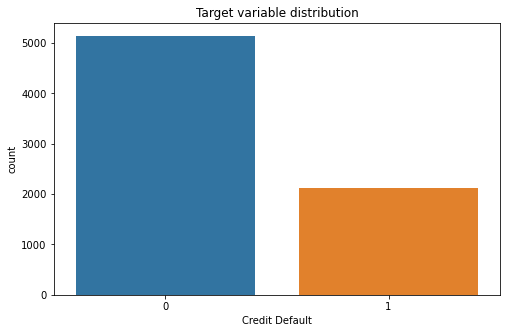

In [25]:
plt.figure(figsize=(8, 5))

sns.countplot(x = TARGET_NAME, data = df_train)

plt.title('Target variable distribution')
plt.show()

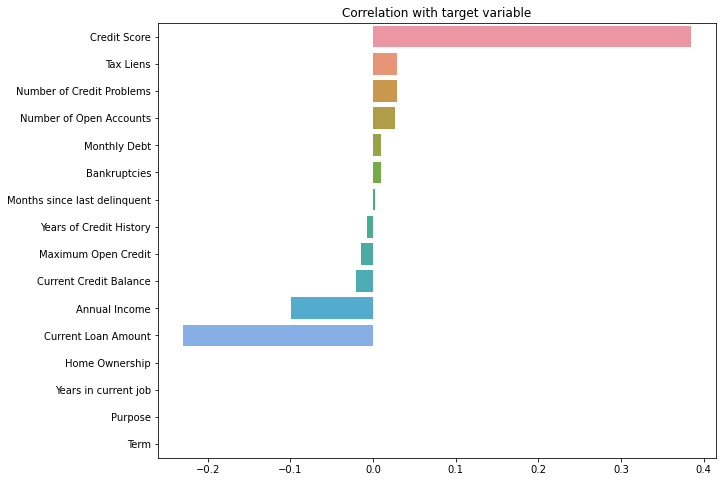

In [26]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

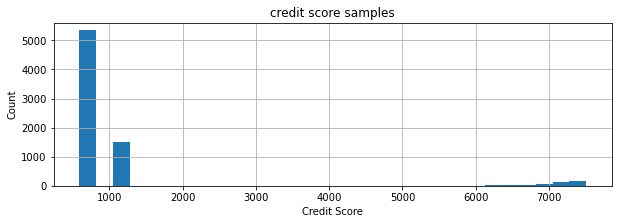

In [27]:
plt.figure(figsize = (10, 3))

df_train['Credit Score'].hist(bins=30, )
plt.ylabel('Count')
plt.xlabel('Credit Score')

plt.title('credit score samples')
plt.show()

In [28]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

# CatBoost

In [29]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11)

cat_model = catb.CatBoostClassifier(
    auto_class_weights='Balanced',
    silent=True,
    #depth=3,
    #iterations=70,
    random_state=11,
    #l2_leaf_reg=10,
    )

cat_model.fit(X_train, y_train)

y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test.values, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      3451
           1       0.77      0.89      0.82      1410

    accuracy                           0.89      4861
   macro avg       0.86      0.89      0.87      4861
weighted avg       0.90      0.89      0.89      4861

TEST

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1692
           1       0.52      0.55      0.53       703

    accuracy                           0.72      2395
   macro avg       0.66      0.67      0.66      2395
weighted avg       0.72      0.72      0.72      2395

CONFUSION MATRIX

col_0     0    1
row_0           
0      1328  364
1       316  387
CPU times: user 10 s, sys: 881 ms, total: 10.9 s
Wall time: 4.53 s


# Важность признаков

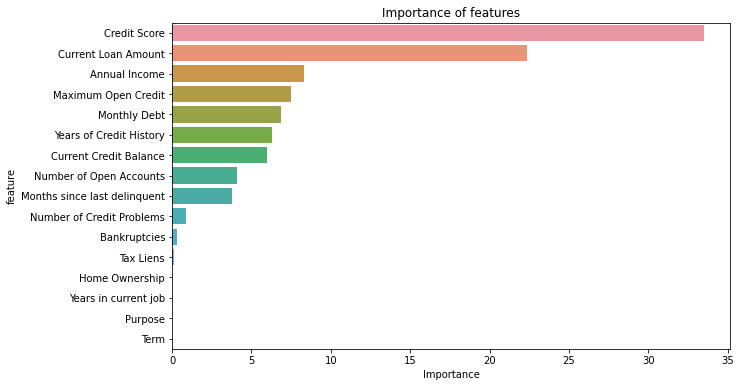

In [32]:
important_features_top = show_feature_importances(X_train.columns, cat_model.feature_importances_, get_top=15)

Снижение степени переобучения

In [33]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [34]:
cv=KFold(n_splits=3, random_state=11, shuffle=True)

In [35]:
%%time

rs = RandomizedSearchCV(cat_model, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 7.13 s, sys: 639 ms, total: 7.77 s
Wall time: 1min 18s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=11, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f3c59323110>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [36]:
rs.best_params_

{'n_estimators': 1000, 'max_depth': 3}

In [37]:
rs.best_score_

0.5423108531523597

#  Финальная модель

In [38]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=11)

final_model = catb.CatBoostClassifier(
    auto_class_weights='Balanced',
    silent=True,
    depth=3,
    #n_estimators=200,
    iterations=1500,
    #l2_leaf_reg=10,
    random_state=11,
    reg_lambda=0.8)

final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test.values, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      3719
           1       0.64      0.82      0.72      1505

    accuracy                           0.81      5224
   macro avg       0.78      0.82      0.79      5224
weighted avg       0.84      0.81      0.82      5224

TEST

              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1424
           1       0.48      0.56      0.52       608

    accuracy                           0.69      2032
   macro avg       0.64      0.65      0.64      2032
weighted avg       0.70      0.69      0.69      2032

CONFUSION MATRIX

col_0     0    1
row_0           
0      1057  367
1       269  339
CPU times: user 8.76 s, sys: 763 ms, total: 9.53 s
Wall time: 4.42 s


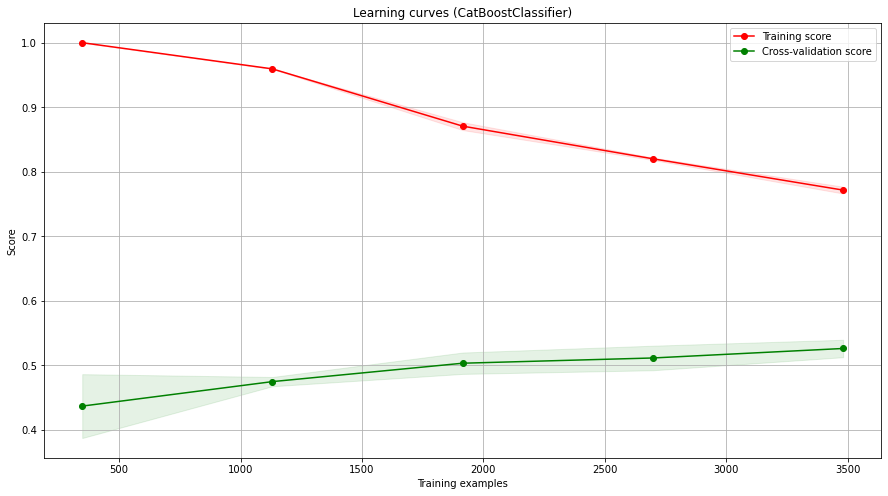

In [41]:
show_learning_curve_plot(final_model, X_train, y_train)

Сохранение финальной модели

In [44]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

IsADirectoryError: [Errno 21] Is a directory: '../working'